# Extract the Diabetes Mention from MIMIC-III dataset documents

In this notebook I will be developing a python script for finding the mention of Diabetes in text documents. This notebook is going to go through the actual MIMIC documents that I have selected to be my training documents. 


First step, import PyConText and define the functions (taken from the PyConText github page and modified with help from Jeff Ferraro) so that I can run the actual text parsing. 

In [1]:
import pyConTextNLP.pyConText as pyConText
# itemData has been rewritten, so that it can take relative local path, where you can redirect it to your customized yml files later
import os
import itemData
import re
import glob
import pandas as pd
from xml.etree import ElementTree
import math

# Set distance for each modification type
distance_negation = 40
distance_other = 40
distance_hypothetical = 70
distance_type = 70

In [2]:
os.listdir('Yaml_Files')

['A1c_modifiers.yml',
 'Diabetes_modifiers.tab_delimited.txt',
 'Diabetes_targets.yml',
 'A1c_targets.yml',
 'Diabetes_modifiers.yml']

In [3]:
my_targets=itemData.get_items('Yaml_Files/Diabetes_targets.yml')
my_modifiers=itemData.get_items('Yaml_Files/Diabetes_modifiers.yml')

The functions *markup_sentence* and *markup_doc* were both ones that we went over in the NLP lab.

In [4]:
## This one is the same, it just doesn't split it into sentences. 
def markup_sentence(s, modifiers, targets, prune_inactive=True):
    """
    """
    markup = pyConText.ConTextMarkup()
    markup.setRawText(s)
    markup.cleanText()
    markup.markItems(my_modifiers, mode="modifier")
    markup.markItems(my_targets, mode="target")
    markup.pruneMarks()
    markup.dropMarks('Exclusion')
    # apply modifiers to any targets within the modifiers scope
    markup.applyModifiers()
    markup.pruneSelfModifyingRelationships()
    if prune_inactive:
        markup.dropInactiveModifiers()
    return markup

def markup_doc(doc_text:str)->pyConText.ConTextDocument:
    rslts=[]
    context = pyConText.ConTextDocument()
    def markup_doc(doc_text:str)->pyConText.ConTextDocument:
        rslts=[]
        context = pyConText.ConTextDocument()
#         for s in doc_text.split('.'):
#             m = markup_sentence(s, modifiers=my_modifiers, targets=my_targets)
#             rslts.append(m)

    #for s in doc_text.split('.'):
    m = markup_sentence(doc_text, modifiers=my_modifiers, targets=my_targets)
    rslts.append(m)

    for r in rslts:
        context.addMarkup(r)
    return context

def get_output(something):
    context=markup_doc(something)
    output = context.getDocumentGraph()
    return output

Ok, I have figured out how to get the pieces of a node that I can use for every node. I can put these into lists and then add the lists into a dataframe, then transpose the dataframe and I can have something to work with. The next step is going to be reading in the documents and figuring out how to apply 

In [5]:
os.listdir('Text_Files/')

['.DS_Store',
 'Training_Dataset',
 'test_files.txt',
 'Testing_Dataset',
 'list_of_Files.txt']

In [6]:
import glob
list_of_files = glob.glob("Text_Files/Testing_Dataset/*.txt")
print(len(list_of_files))
list_of_files[0:3]
#len(list_of_files)

75


['Text_Files/Testing_Dataset/750400.txt',
 'Text_Files/Testing_Dataset/1520872.txt',
 'Text_Files/Testing_Dataset/1671892.txt']

In [7]:
replaced_list = [w.replace('Text_Files/Testing_Dataset/', '') for w in list_of_files] 
list_of_identifiers = [i.replace(".txt", "") for i in replaced_list] 
print(list_of_identifiers[0:10])

['750400', '1520872', '1671892', '502100', '542040', '460197', '612341', '499708', '1874098', '1028562']


In [8]:
list_of_text = [] 
for file in list_of_files:
    text_file = open(file, 'r')
    list_of_text.append(text_file.read()) # Not Readlines
    text_file.close()

In [9]:
print(list_of_text[0])

[**2642-3-27**] 11:24 AM
 CHEST (PORTABLE AP)                                             Clip # [**Clip Number (Radiology) 107400**]
 Reason: please confirm right arm picc tip; page 0-2443 with results.
 ______________________________________________________________________________
 UNDERLYING MEDICAL CONDITION:
  63 year old woman with bilateral pneumococcal pneumonia with effusions,
  sepsis, s/p tube thoracostomy and now s/p tracheostomy with new NG tube
  placement.

  Requiring longterm access with triple lumen cl out.
 REASON FOR THIS EXAMINATION:
  please confirm right arm picc tip; page 0-2443 with results. thanks
 ______________________________________________________________________________
                                 FINAL REPORT
 INDICATION:  For PICC line placement in patient with pneumonia and
 tracheostomy.

 FINDINGS:  PICC line is in the right brachiocephalic vein. Tracheostomy tube
 is 3 cm above carina. Chest tube is in right upper hemithorax. The tube
 extends

In [10]:
text_df = pd.DataFrame({"Identifier" : list_of_identifiers, "Text": list_of_text}) 
text_df.head()

,Identifier,Text
0,750400,[**2642-3-27**] 11:24 AM\n CHEST (PORTABLE AP)...
1,1520872,Neonatology Attending\n\nDOL 127 PMA 42 6/7 we...
2,1671892,Nursing note addendum\nPalliative care consult...
3,502100,TITLE:\n Chief Complaint:\n 24 Hour Events...
4,542040,61 year old male s/p replacement of L perc ne...


In [11]:
i = 0
output_array = []
while i < len(text_df):
    raw_text = text_df["Text"][i]
    remove_MIMIC_comments = re.sub(r"\[\*\*.*?\*\*\]", "", raw_text)
    remove_times = re.sub(r"\d{1,2}:\d{2}\s?P?A?\.?M\.?", "", remove_MIMIC_comments)
    cleaned_text = re.sub(r"\s{2,}", r" ", remove_times)
    
    context=markup_doc(cleaned_text)
    root = ElementTree.fromstring(context.getDocumentGraph().getXML())
    for node in root.findall('.//node'):
        phrase = node.find('.//phrase').text
        #tmp1 =  re.sub(r"[A|a]1[C|c]", "", phrase)
        #A1c_Value = re.sub(r"[^\d{1,2}\.?\d{0,1}]", "", tmp1)
        #A1c_Flag = get_a1c_flag(A1c_Value)
        literal = node.find('.//literal').text
        Start = node.find('.//spanStart').text
        Stop = node.find('.//spanStop').text
        Node_ID = node.find('.//id').text
        category = node.find('./category').text #This picks up target or modifier, not useful
        try:
            modified_by = node.find('.//modifyingNode').text
        except:
            modified_by = "None"
        try:
            modifying_category = node.find('.//modifyingCategory').text
        except:
            modifying_category = "None"
        try:
            node_modified = node.find('.//modifiedNode').text
        except:
            node_modified = "None"
        output_array.append([text_df["Identifier"][i], Start, Stop, phrase, literal, Node_ID,
                             modifying_category, modified_by, node_modified])
    i += 1
            
#output_array

In [12]:
# output_array

In [13]:
# raw_text = text_df["Text"][1]
# remove_MIMIC_comments = re.sub(r"\[\*\*.*?\*\*\]", "", raw_text)
# remove_times = re.sub(r"\d{1,2}:\d{2}\s?P?A?\.?M\.?", "", remove_MIMIC_comments)
# cleaned_text = re.sub(r"\s{2,}", r" ", remove_times)
    
# context=markup_doc(cleaned_text)
# root = ElementTree.fromstring(context.getDocumentGraph().getXML())
# for node in root.findall('.//node'):
#     phrase = node.find('.//phrase').text
#         #tmp1 =  re.sub(r"[A|a]1[C|c]", "", phrase)
#         #A1c_Value = re.sub(r"[^\d{1,2}\.?\d{0,1}]", "", tmp1)
#         #A1c_Flag = get_a1c_flag(A1c_Value)
#     literal = node.find('.//literal').text
#     Start = node.find('.//spanStart').text
#     Stop = node.find('.//spanStop').text
#     Node_ID = node.find('.//id').text
#     category = node.find('./category').text #This picks up target or modifier, not useful
#     try:
#         modified_by = node.find('.//modifyingNode').text
#     except:
#         modified_by = "None"
#     try:
#         modifying_category = node.find('.//modifyingCategory').text
#     except:
#         modifying_category = "None"
#     try:
#         node_modified = node.find('.//modifiedNode').text
#     except:
#         node_modified = "None"
#     output_array.append([text_df["Identifier"][1], Start, Stop, phrase, literal, Node_ID, modifying_category, modified_by, node_modified])

In [14]:
output_array
train_df = pd.DataFrame(output_array, columns=("Identifier", "Start", "Stop", "Phrase", "Annotation_Type", "Node_ID", "Modifying_Category", "Modified_By", "Node_Modified"))
train_df

,Identifier,Start,Stop,Phrase,Annotation_Type,Node_ID,Modifying_Category,Modified_By,Node_Modified
0,502100,4675,4681,likely,HYPOTHETICAL_DIABETES,21786416702006282756421442693092627263,None,None,21787241467178056248175791485615625023
1,502100,4899,4902,not,NOT,21786934854189126045189304470527824703,None,None,21787241467178056248175791485615625023
2,502100,5026,5028,DM,DM,21787241467178056248175791485615625023,['diabetes_type_1'],21785327314771711621779531463775507263,None
3,502100,5030,5034,IDDM,IDDM,21788184282311975993793154658624623423,['diabetes_type_1'],21785327314771711621779531463775507263,None
4,502100,5079,5086,insulin,DIABETES_TYPE_1,21785327314771711621779531463775507263,None,None,21787241467178056248175791485615625023
5,502100,5398,5406,diabetic,DIABETES_OR_DIABETIC,21787144016538163703040551426556711743,['diabetes_type_1'],21785327314771711621779531463775507263,None
6,542040,319,324,never,NOT,21791216344091396889992859585603982143,None,None,21791297156817161439617205000433324863
7,542040,880,897,diabetes Mellitus,DIABETES_OR_DIABETIC,21791297156817161439617205000433324863,['diabetes_type_2'],21790988166983355808700590179027014463,None
8,542040,899,901,DM,DM,21791331224927042573282370224331969343,['diabetes_type_2'],21790988166983355808700590179027014463,None
9,542040,904,911,Type II,DIABETES_TYPE_2,21790988166983355808700590179027014463,None,None,21791297156817161439617205000433324863


In [15]:
# modifier_columns = train_df[train_df["Node_Modified"]!="None"]
# modifier_columns
modifier_columns = train_df[train_df["Node_Modified"]!="None"]
Diabetes_Results = train_df.drop(modifier_columns.index, axis = 0)
print(len(Diabetes_Results))
print(len(modifier_columns))

59
226


In [16]:
modifier_columns

,Identifier,Start,Stop,Phrase,Annotation_Type,Node_ID,Modifying_Category,Modified_By,Node_Modified
0,502100,4675,4681,likely,HYPOTHETICAL_DIABETES,21786416702006282756421442693092627263,None,None,21787241467178056248175791485615625023
1,502100,4899,4902,not,NOT,21786934854189126045189304470527824703,None,None,21787241467178056248175791485615625023
4,502100,5079,5086,insulin,DIABETES_TYPE_1,21785327314771711621779531463775507263,None,None,21787241467178056248175791485615625023
6,542040,319,324,never,NOT,21791216344091396889992859585603982143,None,None,21791297156817161439617205000433324863
9,542040,904,911,Type II,DIABETES_TYPE_2,21790988166983355808700590179027014463,None,None,21791297156817161439617205000433324863
10,542040,1173,1175,No,NOT,21791255165891028879518280422139646783,None,None,21791297156817161439617205000433324863
12,612341,255,257,No,NOT,21799899750702960261393112002560807743,None,None,21800834643020628580576715821174772543
13,612341,577,580,not,NOT,21799926688278215111267893807503921983,None,None,21800834643020628580576715821174772543
14,612341,656,663,without,NOT,21799936987939341965631780968217465663,None,None,21800834643020628580576715821174772543
15,612341,1202,1204,no,NOT,21799959964106471102289683095963063103,None,None,21800834643020628580576715821174772543


In [17]:
Diabetes_Results

,Identifier,Start,Stop,Phrase,Annotation_Type,Node_ID,Modifying_Category,Modified_By,Node_Modified
2,502100,5026,5028,DM,DM,21787241467178056248175791485615625023,['diabetes_type_1'],21785327314771711621779531463775507263,None
3,502100,5030,5034,IDDM,IDDM,21788184282311975993793154658624623423,['diabetes_type_1'],21785327314771711621779531463775507263,None
5,502100,5398,5406,diabetic,DIABETES_OR_DIABETIC,21787144016538163703040551426556711743,['diabetes_type_1'],21785327314771711621779531463775507263,None
7,542040,880,897,diabetes Mellitus,DIABETES_OR_DIABETIC,21791297156817161439617205000433324863,['diabetes_type_2'],21790988166983355808700590179027014463,None
8,542040,899,901,DM,DM,21791331224927042573282370224331969343,['diabetes_type_2'],21790988166983355808700590179027014463,None
11,612341,205,210,NIDDM,NIDDM,21800834643020628580576715821174772543,['diabetes_type_1'],21799194620056583308788529461402817343,None
19,612341,2652,2669,Diabetes Mellitus,DIABETES_OR_DIABETIC,21800177841553385329218065341826487103,['diabetes_type_1'],21799194620056583308788529461402817343,None
20,612341,2671,2673,DM,DM,21800263407968900734702666369292849983,['diabetes_type_1'],21799194620056583308788529461402817343,None
22,612341,2704,2706,Dm,DM,21800272123066777303779801659127386943,['diabetes_type_1'],21799194620056583308788529461402817343,None
25,612341,3147,3155,diabetic,DIABETES_OR_DIABETIC,21800197648594013895302463727814071103,['diabetes_type_1'],21799212050252336446942800041071891263,None


In [18]:
node_locations = Diabetes_Results[["Start", "Stop", "Node_ID"]]
node_locations.head()

,Start,Stop,Node_ID
2,5026,5028,21787241467178056248175791485615625023
3,5030,5034,21788184282311975993793154658624623423
5,5398,5406,21787144016538163703040551426556711743
7,880,897,21791297156817161439617205000433324863
8,899,901,21791331224927042573282370224331969343


In [19]:
node_locations.rename(columns={"Start":"Node_Start", "Stop":"Node_Stop", "Node_ID":"Node_Modified"}, inplace = True)
node_locations.head()

/Users/david/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


,Node_Start,Node_Stop,Node_Modified
2,5026,5028,21787241467178056248175791485615625023
3,5030,5034,21788184282311975993793154658624623423
5,5398,5406,21787144016538163703040551426556711743
7,880,897,21791297156817161439617205000433324863
8,899,901,21791331224927042573282370224331969343


In [20]:
modifier_columns = pd.merge(modifier_columns, node_locations, on='Node_Modified') #, how='right'
modifier_columns = modifier_columns[pd.notnull(modifier_columns['Identifier'])] # Drop the ones that weren't modifier nodes
modifier_columns

,Identifier,Start,Stop,Phrase,Annotation_Type,Node_ID,Modifying_Category,Modified_By,Node_Modified,Node_Start,Node_Stop
0,502100,4675,4681,likely,HYPOTHETICAL_DIABETES,21786416702006282756421442693092627263,None,None,21787241467178056248175791485615625023,5026,5028
1,502100,4899,4902,not,NOT,21786934854189126045189304470527824703,None,None,21787241467178056248175791485615625023,5026,5028
2,502100,5079,5086,insulin,DIABETES_TYPE_1,21785327314771711621779531463775507263,None,None,21787241467178056248175791485615625023,5026,5028
3,542040,319,324,never,NOT,21791216344091396889992859585603982143,None,None,21791297156817161439617205000433324863,880,897
4,542040,904,911,Type II,DIABETES_TYPE_2,21790988166983355808700590179027014463,None,None,21791297156817161439617205000433324863,880,897
5,542040,1173,1175,No,NOT,21791255165891028879518280422139646783,None,None,21791297156817161439617205000433324863,880,897
6,612341,255,257,No,NOT,21799899750702960261393112002560807743,None,None,21800834643020628580576715821174772543,205,210
7,612341,577,580,not,NOT,21799926688278215111267893807503921983,None,None,21800834643020628580576715821174772543,205,210
8,612341,656,663,without,NOT,21799936987939341965631780968217465663,None,None,21800834643020628580576715821174772543,205,210
9,612341,1202,1204,no,NOT,21799959964106471102289683095963063103,None,None,21800834643020628580576715821174772543,205,210


In [21]:
modifier_columns["Distance"] = modifier_columns.apply(lambda x: max((int(x["Start"]) - int(x["Node_Stop"])), (int(x["Node_Start"])-int(x["Stop"]))), axis = 1)
modifier_columns

,Identifier,Start,Stop,Phrase,Annotation_Type,Node_ID,Modifying_Category,Modified_By,Node_Modified,Node_Start,Node_Stop,Distance
0,502100,4675,4681,likely,HYPOTHETICAL_DIABETES,21786416702006282756421442693092627263,None,None,21787241467178056248175791485615625023,5026,5028,345
1,502100,4899,4902,not,NOT,21786934854189126045189304470527824703,None,None,21787241467178056248175791485615625023,5026,5028,124
2,502100,5079,5086,insulin,DIABETES_TYPE_1,21785327314771711621779531463775507263,None,None,21787241467178056248175791485615625023,5026,5028,51
3,542040,319,324,never,NOT,21791216344091396889992859585603982143,None,None,21791297156817161439617205000433324863,880,897,556
4,542040,904,911,Type II,DIABETES_TYPE_2,21790988166983355808700590179027014463,None,None,21791297156817161439617205000433324863,880,897,7
5,542040,1173,1175,No,NOT,21791255165891028879518280422139646783,None,None,21791297156817161439617205000433324863,880,897,276
6,612341,255,257,No,NOT,21799899750702960261393112002560807743,None,None,21800834643020628580576715821174772543,205,210,45
7,612341,577,580,not,NOT,21799926688278215111267893807503921983,None,None,21800834643020628580576715821174772543,205,210,367
8,612341,656,663,without,NOT,21799936987939341965631780968217465663,None,None,21800834643020628580576715821174772543,205,210,446
9,612341,1202,1204,no,NOT,21799959964106471102289683095963063103,None,None,21800834643020628580576715821174772543,205,210,992


In [22]:
modifier_columns.Annotation_Type.unique()

array([' HYPOTHETICAL_DIABETES ', ' NOT ', ' DIABETES_TYPE_1 ',
       ' DIABETES_TYPE_2 ', ' DENIES ', ' DIABETES_IN_OTHER ',
       ' DIABETES_GESTATIONAL '], dtype=object)

In [23]:
distance_negation = 40
distance_other = 60
distance_hypothetical = 100
distance_type = 100

def out_of_range(anno_type, distance):
    if anno_type == " NOT " or anno_type == " DENIES ":
        if distance <= distance_negation:
            return "Keep"
        else:
            return "Discard"
    elif anno_type == " DIABETES_IN_OTHER ":
        if distance <= distance_other:
            return "Keep"
        else:
            return "Discard"
    elif anno_type == " HYPOTHETICAL_DIABETES ":
        if distance <= distance_hypothetical:
            return "Keep"
        else: 
            return "Discard"
    elif anno_type == " DIABETES_TYPE_1 " or anno_type == " DIABETES_TYPE_2 " or anno_type == " DIABETES_GESTATIONAL " or anno_type == " DIABETES_INSIPIDUS ":
        if distance <= distance_type:
            return "Keep"
        else:
            return "Discard"
    else:
        return "Didn't Work"
        
#Merged_Manual_and_Machine["Category"] = Merged_Manual_and_Machine.apply(lambda x: get_category(x["HbA1c"], x["A1c_Value"]), axis = 1)

#modifier_columns
#modifier_columns["Distance"] = modifier_columns.apply(lambda x: max((int(x["Start"]) - int(x["Node_Stop"])), (int(x["Node_Start"])-int(x["Stop"]))), axis = 1)

In [24]:
modifier_columns["Keep"] = modifier_columns.apply(lambda x: out_of_range(x["Annotation_Type"], int(x["Distance"])), axis = 1)
modifier_columns

,Identifier,Start,Stop,Phrase,Annotation_Type,Node_ID,Modifying_Category,Modified_By,Node_Modified,Node_Start,Node_Stop,Distance,Keep
0,502100,4675,4681,likely,HYPOTHETICAL_DIABETES,21786416702006282756421442693092627263,None,None,21787241467178056248175791485615625023,5026,5028,345,Discard
1,502100,4899,4902,not,NOT,21786934854189126045189304470527824703,None,None,21787241467178056248175791485615625023,5026,5028,124,Discard
2,502100,5079,5086,insulin,DIABETES_TYPE_1,21785327314771711621779531463775507263,None,None,21787241467178056248175791485615625023,5026,5028,51,Keep
3,542040,319,324,never,NOT,21791216344091396889992859585603982143,None,None,21791297156817161439617205000433324863,880,897,556,Discard
4,542040,904,911,Type II,DIABETES_TYPE_2,21790988166983355808700590179027014463,None,None,21791297156817161439617205000433324863,880,897,7,Keep
5,542040,1173,1175,No,NOT,21791255165891028879518280422139646783,None,None,21791297156817161439617205000433324863,880,897,276,Discard
6,612341,255,257,No,NOT,21799899750702960261393112002560807743,None,None,21800834643020628580576715821174772543,205,210,45,Discard
7,612341,577,580,not,NOT,21799926688278215111267893807503921983,None,None,21800834643020628580576715821174772543,205,210,367,Discard
8,612341,656,663,without,NOT,21799936987939341965631780968217465663,None,None,21800834643020628580576715821174772543,205,210,446,Discard
9,612341,1202,1204,no,NOT,21799959964106471102289683095963063103,None,None,21800834643020628580576715821174772543,205,210,992,Discard


In [25]:
modifier_columns = modifier_columns[modifier_columns["Keep"] == "Keep"]
modifier_columns

,Identifier,Start,Stop,Phrase,Annotation_Type,Node_ID,Modifying_Category,Modified_By,Node_Modified,Node_Start,Node_Stop,Distance,Keep
2,502100,5079,5086,insulin,DIABETES_TYPE_1,21785327314771711621779531463775507263,None,None,21787241467178056248175791485615625023,5026,5028,51,Keep
4,542040,904,911,Type II,DIABETES_TYPE_2,21790988166983355808700590179027014463,None,None,21791297156817161439617205000433324863,880,897,7,Keep
17,499708,2621,2625,RISK,HYPOTHETICAL_DIABETES,21806828253514832677715667421017690943,None,None,21808515813376386508106409907159847743,2636,2644,11,Keep
52,537156,22,28,type I,DIABETES_TYPE_1,21830481821433466295704219967390503743,None,None,21831896044134345914130264726904001343,29,31,1,Keep
103,343158,979,986,Type II,DIABETES_TYPE_2,21872811844101587445993698629176021823,None,None,21873069335629758805090877647014613823,955,972,7,Keep
104,343158,1035,1042,Insulin,DIABETES_TYPE_1,21872734200502323466942856956104692543,None,None,21873069335629758805090877647014613823,955,972,63,Keep
111,1828632,87,96,gestation,DIABETES_GESTATIONAL,21888529126981167205285505878043677503,None,None,21889088477808517911508916298333049663,117,121,21,Keep
112,1828632,105,111,mother,DIABETES_IN_OTHER,21888324718321880403294514534651810623,None,None,21889088477808517911508916298333049663,117,121,6,Keep
125,26293,377,383,Mother,DIABETES_IN_OTHER,21895834755846607519855006565704160063,None,None,21897246601702611710350923518899147583,406,414,23,Keep
126,26293,388,405,insulin dependent,DIABETES_TYPE_1,21896100170191030305385944937937785663,None,None,21897246601702611710350923518899147583,406,414,1,Keep


Now I only have the modifiers that are within a specified distance (50 characters) of the node they modify.

In [26]:
def get_negated(value):
    if value == " DENIES ":
        return "Negated_Diabetes"
    elif value == " NOT ":
        return "Negated_Diabetes"
    else:
        return ""
    
def get_other(value):
    if value == " DIABETES_IN_OTHER ":
        return "Diabetes_in_other"
    else:
        return ""
    
def get_type(value):
    if value == " DIABETES_TYPE_1 ":
        return "Diabetes_Type_1"
    elif value == " DIABETES_TYPE_2 ":
        return "Diabetes_Type_2"
    elif value == " DIABETES_GESTATIONAL ":
        return "Diabetes_Gestational"
    elif value == " INSIPIDUS ":
        return "Diabetes_Insipidus"
    else:
        return "No_Type"
    
    
    

def get_hypothetical(value):
    if value == " HYPOTHETICAL_DIABETES ":
        return "Diabetes_Hypothetical"
    else:
        return ""

modifier_columns["Negated"] = modifier_columns["Annotation_Type"].apply(get_negated)
modifier_columns["Diabetes_in_other"] = modifier_columns["Annotation_Type"].apply(get_other)
modifier_columns["Type"] = modifier_columns["Annotation_Type"].apply(get_type)
modifier_columns["Hypothetical"] = modifier_columns["Annotation_Type"].apply(get_hypothetical)

/Users/david/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/david/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/david/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/sta

In [27]:
modifier_columns

,Identifier,Start,Stop,Phrase,Annotation_Type,Node_ID,Modifying_Category,Modified_By,Node_Modified,Node_Start,Node_Stop,Distance,Keep,Negated,Diabetes_in_other,Type,Hypothetical
2,502100,5079,5086,insulin,DIABETES_TYPE_1,21785327314771711621779531463775507263,None,None,21787241467178056248175791485615625023,5026,5028,51,Keep,,,Diabetes_Type_1,
4,542040,904,911,Type II,DIABETES_TYPE_2,21790988166983355808700590179027014463,None,None,21791297156817161439617205000433324863,880,897,7,Keep,,,Diabetes_Type_2,
17,499708,2621,2625,RISK,HYPOTHETICAL_DIABETES,21806828253514832677715667421017690943,None,None,21808515813376386508106409907159847743,2636,2644,11,Keep,,,No_Type,Diabetes_Hypothetical
52,537156,22,28,type I,DIABETES_TYPE_1,21830481821433466295704219967390503743,None,None,21831896044134345914130264726904001343,29,31,1,Keep,,,Diabetes_Type_1,
103,343158,979,986,Type II,DIABETES_TYPE_2,21872811844101587445993698629176021823,None,None,21873069335629758805090877647014613823,955,972,7,Keep,,,Diabetes_Type_2,
104,343158,1035,1042,Insulin,DIABETES_TYPE_1,21872734200502323466942856956104692543,None,None,21873069335629758805090877647014613823,955,972,63,Keep,,,Diabetes_Type_1,
111,1828632,87,96,gestation,DIABETES_GESTATIONAL,21888529126981167205285505878043677503,None,None,21889088477808517911508916298333049663,117,121,21,Keep,,,Diabetes_Gestational,
112,1828632,105,111,mother,DIABETES_IN_OTHER,21888324718321880403294514534651810623,None,None,21889088477808517911508916298333049663,117,121,6,Keep,,Diabetes_in_other,No_Type,
125,26293,377,383,Mother,DIABETES_IN_OTHER,21895834755846607519855006565704160063,None,None,21897246601702611710350923518899147583,406,414,23,Keep,,Diabetes_in_other,No_Type,
126,26293,388,405,insulin dependent,DIABETES_TYPE_1,21896100170191030305385944937937785663,None,None,21897246601702611710350923518899147583,406,414,1,Keep,,,Diabetes_Type_1,


In [28]:
def max_len(s):
    return max(s, key=len)
def max_val(s):
    return max(s, key=int)
subset = modifier_columns.groupby("Node_Modified").agg({'Diabetes_in_other': max_len, "Hypothetical": max_len, "Negated": max_len, "Type": max_len, "Distance": max_val})


In [29]:
Diabetes_Results

,Identifier,Start,Stop,Phrase,Annotation_Type,Node_ID,Modifying_Category,Modified_By,Node_Modified
2,502100,5026,5028,DM,DM,21787241467178056248175791485615625023,['diabetes_type_1'],21785327314771711621779531463775507263,None
3,502100,5030,5034,IDDM,IDDM,21788184282311975993793154658624623423,['diabetes_type_1'],21785327314771711621779531463775507263,None
5,502100,5398,5406,diabetic,DIABETES_OR_DIABETIC,21787144016538163703040551426556711743,['diabetes_type_1'],21785327314771711621779531463775507263,None
7,542040,880,897,diabetes Mellitus,DIABETES_OR_DIABETIC,21791297156817161439617205000433324863,['diabetes_type_2'],21790988166983355808700590179027014463,None
8,542040,899,901,DM,DM,21791331224927042573282370224331969343,['diabetes_type_2'],21790988166983355808700590179027014463,None
11,612341,205,210,NIDDM,NIDDM,21800834643020628580576715821174772543,['diabetes_type_1'],21799194620056583308788529461402817343,None
19,612341,2652,2669,Diabetes Mellitus,DIABETES_OR_DIABETIC,21800177841553385329218065341826487103,['diabetes_type_1'],21799194620056583308788529461402817343,None
20,612341,2671,2673,DM,DM,21800263407968900734702666369292849983,['diabetes_type_1'],21799194620056583308788529461402817343,None
22,612341,2704,2706,Dm,DM,21800272123066777303779801659127386943,['diabetes_type_1'],21799194620056583308788529461402817343,None
25,612341,3147,3155,diabetic,DIABETES_OR_DIABETIC,21800197648594013895302463727814071103,['diabetes_type_1'],21799212050252336446942800041071891263,None


In [30]:
subset = subset.reset_index()
subset.rename(columns={"Node_Modified":"Node_ID"}, inplace = True)
subset

,Node_ID,Diabetes_in_other,Hypothetical,Negated,Type,Distance
0,21787241467178056248175791485615625023,,,,Diabetes_Type_1,51
1,21791297156817161439617205000433324863,,,,Diabetes_Type_2,7
2,21808515813376386508106409907159847743,,Diabetes_Hypothetical,,No_Type,11
3,21831896044134345914130264726904001343,,,,Diabetes_Type_1,1
4,21873069335629758805090877647014613823,,,,Diabetes_Type_2,63
5,21889088477808517911508916298333049663,Diabetes_in_other,,,Diabetes_Gestational,21
6,21897246601702611710350923518899147583,Diabetes_in_other,,,Diabetes_Gestational,47
7,21911357929728027331519709631893492543,,,Negated_Diabetes,No_Type,7
8,21937996814810198429748786914314965823,,,,Diabetes_Type_2,1
9,21946307849057944758762349674705212223,,,,Diabetes_Type_2,1


In [31]:
Final_table = pd.merge(Diabetes_Results, subset, on='Node_ID', how = "left") # how='right'
Final_table

,Identifier,Start,Stop,Phrase,Annotation_Type,Node_ID,Modifying_Category,Modified_By,Node_Modified,Diabetes_in_other,Hypothetical,Negated,Type,Distance
0,502100,5026,5028,DM,DM,21787241467178056248175791485615625023,['diabetes_type_1'],21785327314771711621779531463775507263,None,,,,Diabetes_Type_1,51.0
1,502100,5030,5034,IDDM,IDDM,21788184282311975993793154658624623423,['diabetes_type_1'],21785327314771711621779531463775507263,None,NaN,NaN,NaN,NaN,NaN
2,502100,5398,5406,diabetic,DIABETES_OR_DIABETIC,21787144016538163703040551426556711743,['diabetes_type_1'],21785327314771711621779531463775507263,None,NaN,NaN,NaN,NaN,NaN
3,542040,880,897,diabetes Mellitus,DIABETES_OR_DIABETIC,21791297156817161439617205000433324863,['diabetes_type_2'],21790988166983355808700590179027014463,None,,,,Diabetes_Type_2,7.0
4,542040,899,901,DM,DM,21791331224927042573282370224331969343,['diabetes_type_2'],21790988166983355808700590179027014463,None,NaN,NaN,NaN,NaN,NaN
5,612341,205,210,NIDDM,NIDDM,21800834643020628580576715821174772543,['diabetes_type_1'],21799194620056583308788529461402817343,None,NaN,NaN,NaN,NaN,NaN
6,612341,2652,2669,Diabetes Mellitus,DIABETES_OR_DIABETIC,21800177841553385329218065341826487103,['diabetes_type_1'],21799194620056583308788529461402817343,None,NaN,NaN,NaN,NaN,NaN
7,612341,2671,2673,DM,DM,21800263407968900734702666369292849983,['diabetes_type_1'],21799194620056583308788529461402817343,None,NaN,NaN,NaN,NaN,NaN
8,612341,2704,2706,Dm,DM,21800272123066777303779801659127386943,['diabetes_type_1'],21799194620056583308788529461402817343,None,NaN,NaN,NaN,NaN,NaN
9,612341,3147,3155,diabetic,DIABETES_OR_DIABETIC,21800197648594013895302463727814071103,['diabetes_type_1'],21799212050252336446942800041071891263,None,NaN,NaN,NaN,NaN,NaN


In [32]:
def get_new_type(anno_type, modify_type):
    if anno_type == " DMII " or anno_type == " DM2 " or anno_type == " T2DM " or anno_type == " NIDDM ":
        return "Diabetes_Type_2"
    elif anno_type == " DMI " or anno_type == " DM1 " or anno_type == " T1DM " or anno_type == " IDDM ":
        return "Diabetes_Type_1"
    elif anno_type == " GDM ":
        return "Diabetes_Gestational"
    else:
        if modify_type == "Diabetes_Type_1":
            return "Diabetes_Type_1"
        elif modify_type == "Diabetes_Type_2":
            return "Diabetes_Type_2"
        elif modify_type == "Diabetes_Gestational":
            return "Diabetes_Gestational"
        elif modify_type == "Diabetes_Insipidus":
            return "Diabetes_Insipidus"
        else:
            return "Diabetes_Type_Not_Specified"
        
        

Final_table["Diabetes_Type"] = Final_table.apply(lambda x: get_new_type(x["Annotation_Type"], x["Type"]), axis = 1)


In [33]:
Final_table["Diabetes_Negated"] = Final_table.apply(lambda x: "Negated_Diabetes" if x["Negated"] == "Negated_Diabetes" else None, axis = 1)
Final_table["Diabetes_Hypothetical"] = Final_table.apply(lambda x: "Diabetes_Hypothetical" if x["Hypothetical"] == "Diabetes_Hypothetical" else None, axis = 1)
Final_table["Diabetes_In_Other_Person"] = Final_table.apply(lambda x: "Diabetes_in_other" if x["Diabetes_in_other"] == "Diabetes_in_other" else None, axis = 1)


Final_table

,Identifier,Start,Stop,Phrase,Annotation_Type,Node_ID,Modifying_Category,Modified_By,Node_Modified,Diabetes_in_other,Hypothetical,Negated,Type,Distance,Diabetes_Type,Diabetes_Negated,Diabetes_Hypothetical,Diabetes_In_Other_Person
0,502100,5026,5028,DM,DM,21787241467178056248175791485615625023,['diabetes_type_1'],21785327314771711621779531463775507263,None,,,,Diabetes_Type_1,51.0,Diabetes_Type_1,None,None,None
1,502100,5030,5034,IDDM,IDDM,21788184282311975993793154658624623423,['diabetes_type_1'],21785327314771711621779531463775507263,None,NaN,NaN,NaN,NaN,NaN,Diabetes_Type_1,None,None,None
2,502100,5398,5406,diabetic,DIABETES_OR_DIABETIC,21787144016538163703040551426556711743,['diabetes_type_1'],21785327314771711621779531463775507263,None,NaN,NaN,NaN,NaN,NaN,Diabetes_Type_Not_Specified,None,None,None
3,542040,880,897,diabetes Mellitus,DIABETES_OR_DIABETIC,21791297156817161439617205000433324863,['diabetes_type_2'],21790988166983355808700590179027014463,None,,,,Diabetes_Type_2,7.0,Diabetes_Type_2,None,None,None
4,542040,899,901,DM,DM,21791331224927042573282370224331969343,['diabetes_type_2'],21790988166983355808700590179027014463,None,NaN,NaN,NaN,NaN,NaN,Diabetes_Type_Not_Specified,None,None,None
5,612341,205,210,NIDDM,NIDDM,21800834643020628580576715821174772543,['diabetes_type_1'],21799194620056583308788529461402817343,None,NaN,NaN,NaN,NaN,NaN,Diabetes_Type_2,None,None,None
6,612341,2652,2669,Diabetes Mellitus,DIABETES_OR_DIABETIC,21800177841553385329218065341826487103,['diabetes_type_1'],21799194620056583308788529461402817343,None,NaN,NaN,NaN,NaN,NaN,Diabetes_Type_Not_Specified,None,None,None
7,612341,2671,2673,DM,DM,21800263407968900734702666369292849983,['diabetes_type_1'],21799194620056583308788529461402817343,None,NaN,NaN,NaN,NaN,NaN,Diabetes_Type_Not_Specified,None,None,None
8,612341,2704,2706,Dm,DM,21800272123066777303779801659127386943,['diabetes_type_1'],21799194620056583308788529461402817343,None,NaN,NaN,NaN,NaN,NaN,Diabetes_Type_Not_Specified,None,None,None
9,612341,3147,3155,diabetic,DIABETES_OR_DIABETIC,21800197648594013895302463727814071103,['diabetes_type_1'],21799212050252336446942800041071891263,None,NaN,NaN,NaN,NaN,NaN,Diabetes_Type_Not_Specified,None,None,None


In [34]:
Final_table.to_csv("Output_Files/Diabetes_mention_Test_Dataset.csv")

There are too many of these that have two or more mentions per document. I am just going to get the counts of correct or incorrect using Excel and comparing them. 

Ok, now for the contingency tables of picking up diabetes results
This took too long to try it here, so I just ran it in Excel

	Count	Recall	Precision	F-Value
Diabetes Mention	106	100	100	100
Hypothetical Mention	0	0	0	0
Type not Specified	27	65.85	100	79.41
Type 1	11	100	54.54	70.59
Type 2	18	100	61.11	75.86
Gestational	0	0	0	0
Insipidus	0	0	0	0
Negated Diabetes	1	100	100	100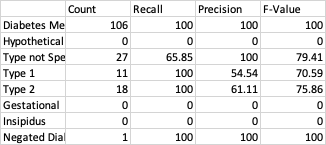


Now for the test data, and then deployment